# Reccurent Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm import tqdm
import yfinance as yf

## Import Financial Data

In [2]:
msft = yf.Ticker("MSFT")
hist = msft.history(period='max')

In [3]:
BTC = yf.Ticker("BTC")
hist = BTC.history(period='max')

## Data Loader for Stock/Crypto Price Data
 - Take daily price data
 - Can also add high/low/volume?

In [4]:
# Select random windows from time series data

def getwindows(dataX, dataY, windowsize, trainsplit):
	N = len(dataX)
	nwindows = int(N/windowsize)
	ntrain = int(trainsplit*nwindows)

	starts = np.arange(nwindows)*windowsize
	np.random.shuffle(starts)
	trainpos = starts[:ntrain]
	valpos = starts[ntrain:]

	trainwindows = []
	traintarget = []
	valwindows = []
	valtarget = []
	for idx in trainpos:
		trainwindows.append(dataX[idx:idx+windowsize])
		traintarget.append(dataY[idx:idx+windowsize])
	for idx in valpos:
		valwindows.append(dataX[idx:idx+windowsize])
		valtarget.append(dataY[idx:idx+windowsize])

	return np.array(trainwindows), np.array(traintarget), np.array(valwindows), np.array(valtarget)

x = np.random.rand(2000,10)
y = np.random.rand(2000,5)

tx, ty, vx, vy = getwindows(x, y, 100, .80)
print(tx.shape)
print(ty.shape)
print(vx.shape)
print(vy.shape)

(16, 100, 10)
(16, 100, 5)
(4, 100, 10)
(4, 100, 5)


In [5]:
class StockCryptoDataset(Dataset):
    def __init__(self, dataX, dataY):
        self.trainX = dataX
        self.trainY = dataY

    def __len__(self):
        return len(self.trainX)

    def __getitem__(self, idx):
        return self.trainX[idx], self.trainY[idx]

## Recurrent Neural Network

cpu
datashape (5000, 200)
datashape (5000, 10)


100%|██████████| 20/20 [00:04<00:00,  4.83it/s]


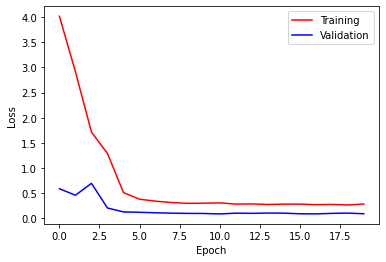

(4, 30, 10)
(4, 30, 10)
[ 0.61386186  0.9031438   0.9997506   0.8830722   0.5780006   0.14961927
 -0.3106816  -0.70470214 -0.9483827  -0.9897368  -0.81994206 -0.47522217
 -0.02911919  0.42319605  0.7852273   0.9797394   0.96523553  0.74480987
  0.36548766 -0.0918071  -0.5295159  -0.8542586  -0.9967552  -0.9266056
 -0.6587755  -0.25040329  0.21138957  0.6280849   0.9107856   0.9991808 ]
[-0.1257466   0.86547035  0.987003    0.90085644  0.63685817  0.16804314
 -0.29429427 -0.6956135  -0.93808734 -0.9829344  -0.7912835  -0.46751207
 -0.0187496   0.44439605  0.7868707   0.97637135  0.96843994  0.7515818
  0.39362174 -0.11697036 -0.52238303 -0.83056223 -0.98312294 -0.9306566
 -0.60905665 -0.26474622  0.23613274  0.62460166  0.93312466  0.98540074]


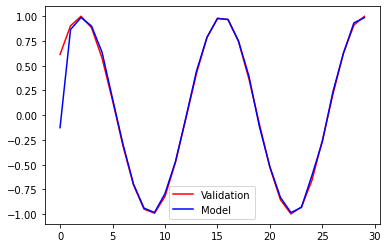

In [6]:
if torch.cuda.is_available():
	DEVICE= torch.device('cuda')
else:   
	DEVICE = torch.device('cpu')
print(DEVICE)

# class FinRNN(nn.Module):
#	 def __init__(self, n_companies, n_crypto):
#		 super(FinCryptoRNN, self).__init__()
#		 self.hidden1 = 100
#		 self.hidden2 = 100

#		 self.rnn = nn.RNN(n_companies, self.hidden1, nonlinearity='relu', batch_first=True)
#		 self.FC1 = nn.Linear(self.hidden1, self.hidden2)
#		 self.FC2 = nn.Linear(self.hidden2, 1)
		
#	 def forward(self, x):
#		 x, hout = self.rnn(x)
#		 # Take final RNN output and feed to Fully Connected Layers
#		 x = self.FC1(x[:, -1, :])
#		 x = torch.relu(x)
#		 x = self.FC2(x)
#		 return x

class FinCryptoRNN(nn.Module):
	def __init__(self, n_companies, n_crypto):
		super(FinCryptoRNN, self).__init__()
		self.hidden1 = 200
		self.hidden2 = 100

		self.rnn1 = nn.RNN(n_companies, self.hidden1, nonlinearity='relu', batch_first=True)
		self.rnn2 = nn.RNN(self.hidden1, self.hidden2, nonlinearity='relu', batch_first=True)
		self.rnn3 = nn.RNN(self.hidden2, n_crypto, nonlinearity='tanh', batch_first=True)
		
	def forward(self, x):
		x, hout = self.rnn1(x)
		x, hout = self.rnn2(x)
		x, hout = self.rnn3(x)
		# Take final RNN output and feed to Fully Connected Layers
		return x
		
# Generate random data
# x = np.random.rand(5000,200)
# y = np.random.rand(5000,10)

# Generate sinusoidal data
x = np.array([np.sin(np.linspace(0,10,5000)*233)])
x = np.repeat(x, 200, axis=0)
x = np.transpose(x)

y = np.array([np.cos(np.linspace(0,10,5000)*233)])
y = np.repeat(y, 10, axis=0)
y = np.transpose(y)
print('datashape', x.shape)
print('datashape', y.shape)

tx, ty, vx, vy = getwindows(x, y, 30, .80)

traindataset = StockCryptoDataset(tx, ty)
valdataset = StockCryptoDataset(vx, vy)

trainloader = DataLoader(traindataset, batch_size=10, shuffle=True)
valloader = DataLoader(valdataset, batch_size=10, shuffle=True)

model = FinCryptoRNN(200, 10).float()

mseloss = nn.MSELoss().float()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

NEPOCHS = 20

tlosses = []
vlosses = []
for i in tqdm(range(NEPOCHS)):
	model.train()
	loss_i = 0
	for stock, crypto in trainloader:
		stock = stock.float()
		crypto = crypto.float()
		outputs = model(stock)
		loss = mseloss(outputs, crypto)
		loss_i += loss.item()
		loss.backward()
		optimizer.step()
		optimizer.zero_grad()
	tlosses.append(loss_i)
	
	model.eval()
	loss_i = 0
	for stock, crypto in valloader:
		stock = stock.float()
		crypto = crypto.float()
		outputs = model(stock)
		loss = mseloss(outputs, crypto)
		loss_i += loss.item()
	vlosses.append(loss_i)

plt.figure()
plt.plot(tlosses, 'r-', label='Training')
plt.plot(vlosses, 'b-', label='Validation')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

crypto = crypto.numpy()
outputs = outputs.detach().numpy()

print(crypto.shape)
print(outputs.shape)
print(crypto[0,:,0])
print(outputs[0,:,0])
plt.figure()
plt.plot(crypto[0,:,0], 'r-', label='Validation')
plt.plot(outputs[0,:,0], 'b-', label='Model')
plt.legend()
plt.show()

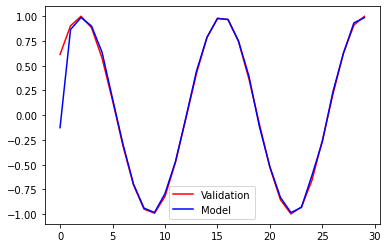

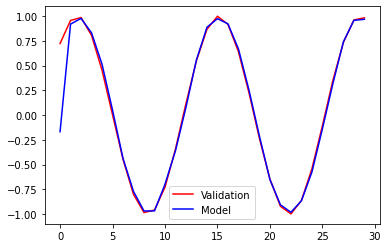

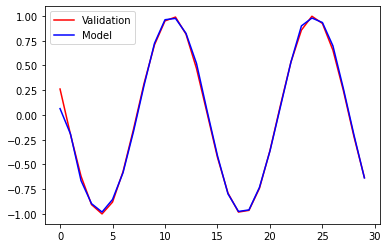

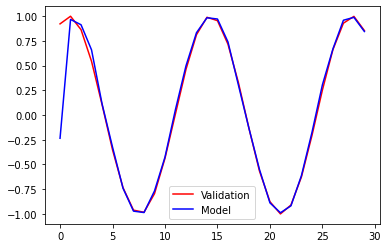

In [7]:
for i in range(4):
	plt.figure()
	plt.plot(crypto[i,:,i], 'r-', label='Validation')
	plt.plot(outputs[i,:,i], 'b-', label='Model')
	plt.legend()
	plt.show()